# Lab 4 - Batch Normalization

In this lab has the following goals:
- Implement functional and module based batch normalization layer.
- Understand the subtleties regarding batchnorm usage, particularly avoiding statistic computation in the test set.
- Introduce the use of `register_buffer` in `torch.nn.Module`.
- Understand the `.eval()` and `.train()` methods of `torch.nn.Module` and what these do. 

**Note:** It is recommended to run the lab mini-experiments on GPU.


**IMPORTANT:** For submission you are **only** required to complete **Part 1**: Functional Batch Normalization. 

## 0 Initialization

Run the code cells below to initialize the train and test loaders of the MNIST dataset and visualize one of the MNIST samples.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets,transforms


# Initialize train and test datasets
train_set = datasets.MNIST('../data',
                           train=True,
                           download=True,
                           transform=transforms.ToTensor())
test_set = datasets.MNIST('../data',
                          train=False,
                          download=True,
                          transform=transforms.ToTensor())

# Initialize train and test data loaders
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=256,
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=256,
                                          shuffle=True,
                                          drop_last=True)

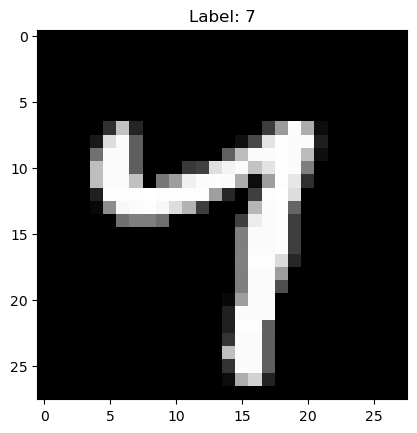

In [9]:
# Visualize a sample from MNIST
X_train_samples, y_train_samples = next(iter(train_loader))
plt.title(f'Label: {y_train_samples[0]}')
plt.imshow((X_train_samples[0].squeeze(0)).numpy(), cmap='gray');

## Exercise 1: Functional Batch Normalization

### 1.1 Batch Normalization Function
Implement a function that performs batch normalization on a given `inputs` tensor of shape `(N, F)`, where `N` is the minibatch size and `F` is the number of features. 

**Note**: Batch normalization performs differently at train and inference time:
* `train`: During training, batch normalization standardizes the given inputs along the minibatch dimension (mean and standard deviation would be of shape `(F,)`) using the equation given below. The running average of the minibatch means and variances are updated during training using the equations on [slide 30 of lecture 4](https://moodle.concordia.ca/moodle/pluginfile.php/5877105/mod_resource/content/2/Lecture_4%20f.pdf). Learnable parameters $\beta$ and $\gamma$ shift and scale the distribution after standardization. $ϵ$ is a constant and will be set to 0.001.
* `eval`: During evaluation (inference), batch normalization uses the running average of the means and standard deviations which were computed during training for normalization.

Implement a functional batch normalization layer with the differentiable affine parameters $\gamma$ and $\beta$. The batch normalization layer has the following formulation:

$$y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$


You will need to create an additional set of variables to track and update the statistics (`toy_stats_dict`). Note that the statistics are updated outside of backpropagation. For the momentum rate of batchnorm statistics use `0.1`.

Your function is then checked in train mode with 100 sample random values $\sim \mathcal{N}(50,10)$ (so shape would be `(100, 1)`. The correct printed output should be (very close to):

    Training Samples
    Before BN: mean tensor([54.8908]), var tensor([8.1866])
    After BN: mean tensor([-1.3208e-06], grad_fn=<MeanBackward1>), var tensor([0.9999], grad_fn=<VarBackward1>)

**Note:** To get these exact same values, your device would need to be set to cpu.


In [17]:
# Set seed
torch.manual_seed(691)

# Number of features
train_size = 500
test_size = 1
num_features = 1

# Generates toy train features for evaluating your function down below
toy_train_features = (torch.rand(train_size, num_features) * 10) + 50

### TODO: Initialize the `running_mean` and `running_var` variables
### with 0 and 1 values respectively.
toy_stats_dict = {
    "running_mean": torch.zeros(num_features),
    "running_var": torch.ones(num_features),
}

### TODO: Initialize the learnable parameters `beta` and `gamma` 
### with 0 and 1 values respectively.
beta = torch.zeros(num_features, requires_grad=True)
gamma = torch.ones(num_features, requires_grad=True)

def batchnorm(inputs, beta, gamma, stats_dict, train=True, eps=0.001, momentum=0.1):
    r"""Performs batch normalization for a single layer of inputs. If in train
    mode, will update the stats_dict dictionary with running mean and variance
    values.

    Args:
        inputs (torch.tensor): Batch of inputs of shape (N, F), where N is 
            the minibatch size, and F is the number of features.
        beta (torch.tensor): Batch normalization beta variable of shape (F,).
        gamma (torch.tensor): Batch normalization gamma variable of shape (F,).
        stats_dict (dict of torch.tensor): Dictionary containing the running
            mean and variance. Expects dictionary to contain keys 'running_mean'
            and 'running_var', with values being `torch.tensor`s of shape (F,).
        train (bool): Determines whether batch norm is in train mode or not.
            Default: True
        eps (float): Constant for numeric stability.
        momentum (float): The momentum value for updating the running mean and
            variance during training.

    Returns:
        torch.tensor: Batch normalized inputs, of shape (N, F)
    """
    ### TODO: Fill out this function
    ave_mean = stats_dict['running_mean']
    ave_var = stats_dict['running_var']
    
    if train:
        
        batch_mean = inputs.mean(0)
        batch_var = inputs.var(0)
        ave_mean = momentum * batch_mean + (1 - momentum) * ave_mean
        ave_var = momentum * batch_var + (1 - momentum) * ave_var
        stats_dict['running_mean'] = ave_mean
        stats_dict['running_var'] = ave_var
        
        return gamma * ((inputs - batch_mean) / ((batch_var + eps) ** 0.5)) + beta
    else:
        
        return gamma * ((inputs - ave_mean) / ((ave_var + eps) ** 0.5)) + beta
        
        
        
# run batchnorm on toy train features
bn_out_train = batchnorm(toy_train_features, beta, gamma, toy_stats_dict)

# print results
print("Training Samples")
print(f"Before BN: mean {toy_train_features.mean(0)}, var {toy_train_features.var(0)}")
print(f"After BN: mean {bn_out_train.mean(0)}, var {bn_out_train.var(0)}\n")

Training Samples
Before BN: mean tensor([54.8908]), var tensor([8.1866])
After BN: mean tensor([-1.3208e-06], grad_fn=<MeanBackward1>), var tensor([0.9999], grad_fn=<VarBackward0>)



### 1.2 Setting up the Model Architecture
For the model architecture, you will use the 2 layer model from labs 2 & 3 (the one that doesnt use `nn.Module`). You will use the batchnorm function defined in part (1.1) at the 2 hidden layers of the network. Batch normalization is typically applied before the activation function!

**Note:** You will need 2 variables one for each layer to track the statistics, i.e., the running mean and variance.

Modify your intialization function that you implemented in lab 3. The function should do the following:
  - Initialize $β$'s with zeros and $γ$'s with ones.
  - Intialize the variables that contain the running mean and variance of each layer. 
  - Intialize all parameters in the network (done in lab 2).

VERY IMPORTANT: Make sure that ALL the trainable parameters require gradient!

In [21]:
# Initialize model hiden layer sizes
h1_size = 50
h2_size = 50

### TODO: Initialize the beta and gamma parameters
beta0 = torch.zeros(h1_size)
gamma0 = torch.ones(h1_size)
beta1 = torch.zeros(h2_size)
gamma1 = torch.ones(h2_size)
device = 'cuda'

# Intentional naive initialization (do not modify)
param_dict = {
    "W0": torch.rand(784, h1_size)*2-1,
    "b0": torch.rand(h1_size)*2-1,
    "beta0": beta0,
    "gamma0": gamma0,
    "W1": torch.rand(h1_size, h2_size)*2-1,
    "b1": torch.rand(h2_size)*2-1,
    "beta1": beta1,
    "gamma1": gamma1,
    "W2": torch.rand(h2_size,10)*2-1,
    "b2": torch.rand(10)*2-1,
}

for name, param in param_dict.items():
    param_dict[name] = param.to(device)
    param_dict[name].requires_grad = True

### TODO: Initialize the `running_mean` and `running_var` variables
### with 0s and 1s respectively.
l1_stats_dict = {
    "running_mean": torch.zeros(h1_size),
    "running_var": torch.ones(h1_size),
}
l2_stats_dict = {
    "running_mean": torch.zeros(h2_size),
    "running_var": torch.ones(h2_size),
}
layers_stats_list = [l1_stats_dict, l2_stats_dict]

def my_nn(input, param_dict, layers_stats_list, train=True):
    r"""Performs a single forward pass of a 2 layer MLP with batch 
    normalization using the given parameters in param_dict and the
    batch norm statistics in layers_stats_list.

    Args:
        input (torch.tensor): Batch of images of shape (N, H, W), where N is 
            the number of input samples, and H and W are the image height and 
            width respectively.
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#", "b#", "beta#" and "gamma#" where # is the layer number.
        layers_stats_list (list of dict of torch.tensor): List of dictionaries
            containing running means and variances for each layer. List size 
            is equal to the number of hidden layers.
        train (bool): Determines whether batch norm is in train mode or not.
            Default: True

    Returns:
        torch.tensor: Neural network output of shape (N, 10)
    """
    x = input.view(-1, 28*28) 

    # layer 1
    x = torch.relu_(x @ param_dict['W0'] + param_dict['b0'])

    ### TODO: use your complete batchnorm function
    x = batchnorm(x, param_dict['beta0'], param_dict['gamma0'], layers_stats_list[0])
    

    # layer 2
    x = torch.relu_(x @ param_dict['W1'] + param_dict['b1'])

    ### TODO: use your complete batchnorm function
    x = batchnorm(x, param_dict['beta1'], param_dict['gamma1'], layers_stats_list[1])

    # output 
    x = x @ param_dict['W2'] + param_dict['b2']
    return x

def my_zero_grad(param_dict):
    r"""Zeros the gradients of the parameters in `param_dict`.

    Args:
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#", "b#", "beta#" and "gamma#" where # is the layer number.
        layers_stats_list (list of dict of torch.tensor): List of dictionaries
            containing running means and variances for each layer. List size 
            is equal to the number of hidden layers.

    Returns:
        None
    """
    for _, param in param_dict.items():
        if param.grad is not None: 
            param.grad.detach_()
            param.grad.zero_()

def initialize_nn(param_dict, layers_stats_list):
    r"""Initializes the parameters in `param_dict` and resets the statistics
    in `layers_stats_list`.

    Args:
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#", "b#", "beta#" and "gamma#" where # is the layer number.
        layers_stats_list (list of dict of torch.tensor): List of dictionaries
            containing running means and variances for each layer. List size 
            is equal to the number of hidden layers.

    Returns:
        None
    """
    ### TODO: Fill out this function
    # Initializes the parameters in `param_dict`
    for name, param in param_dict.items():
        if "beta" in name:
            param_dict[name] = torch.zeros_like(param)
        elif "gamma" in name:
            param_dict[name] = torch.ones_like(param)
        else:
            param_dict[name] = torch.rand_like(param)*2-1

    for name, param in param_dict.items():
        param_dict[name] = param.to(device)
        param_dict[name].requires_grad = True

    # resets the statistics in `layers_stats_list`
    for stats_dict in layers_stats_list:
        stats_dict["running_mean"] = torch.zeros_like(stats_dict["running_mean"], device=device)
        stats_dict["running_var"] = torch.ones_like(stats_dict["running_var"], device=device)
    
    

### 1.3 Training the Model

Train the model on the MNIST dataset with 20 epochs and `lr=0.01` with SGD and without momentum (as per lab 2). Since you are dealing with the MNIST dataset and you are required to perform multiclass classification, you will use the cross entropy loss during training (similar to lab2).

Plot the learning curves for training accuracy recorded every 50 iterations (smoothed output).

The first 5 epochs should have close values to the following output:

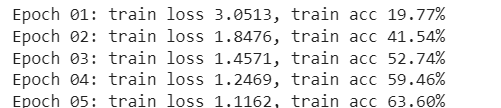

This is a sample output of how your plots should look like:

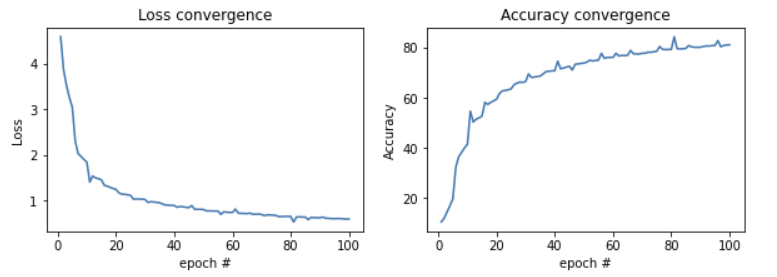

In [44]:
from torch.optim import SGD

# training hyper_parameters
lr = 0.01
num_epochs = 20

### TODO: Initialize optimizer. You can use the SGD class from pytorch.
initialize_nn(param_dict, layers_stats_list)
optimizer = SGD(param_dict.values(), lr)
train_history = {
    'train_loss_hist': [],
    'train_acc_hist': [],
}

for epoch in range(num_epochs):
    total_train_loss = 0
    total_train_acc = 0
    for i, (data, label) in enumerate(train_loader):
        ### TODO: Train the network
        data = data.to(device)
        label = label.to(device)

        scores = my_nn(data, param_dict, layers_stats_list, train=True)
        loss = torch.nn.functional.cross_entropy(scores, label)  

        optimizer.zero_grad() #
        loss.backward() 
        optimizer.step() 

        total_train_loss += loss.item()
        total_train_acc += (scores.max(dim=1)[1] == label).sum() / len(label)

        if i%50 == 0:
          # update train_history
          # compute train_loss_hist & train_acc_hist for each epoch
          # computing metrics across entire epoch reduces noise/variance of the metrics
          train_loss = total_train_loss / (i+1)
          train_acc = 100 * (float(total_train_acc) / (i+1))
          train_history['train_loss_hist'].append(train_loss)
          train_history['train_acc_hist'].append(train_acc)

    # print training progress
    print(f'Epoch {epoch+1:02d}: train loss {train_loss:.4f}, train acc {train_acc:.2f}%')
    

Epoch 01: train loss 4.0359, train acc 23.00%
Epoch 02: train loss 2.1751, train acc 41.98%
Epoch 03: train loss 1.5956, train acc 52.16%
Epoch 04: train loss 1.3176, train acc 58.91%
Epoch 05: train loss 1.1597, train acc 63.13%
Epoch 06: train loss 1.0482, train acc 66.38%
Epoch 07: train loss 0.9693, train acc 68.79%
Epoch 08: train loss 0.9018, train acc 70.89%
Epoch 09: train loss 0.8564, train acc 72.31%
Epoch 10: train loss 0.8107, train acc 73.78%
Epoch 11: train loss 0.7775, train acc 75.09%
Epoch 12: train loss 0.7477, train acc 75.89%
Epoch 13: train loss 0.7226, train acc 76.80%
Epoch 14: train loss 0.6970, train acc 77.62%
Epoch 15: train loss 0.6792, train acc 78.43%
Epoch 16: train loss 0.6567, train acc 79.02%
Epoch 17: train loss 0.6458, train acc 79.56%
Epoch 18: train loss 0.6267, train acc 80.03%
Epoch 19: train loss 0.6074, train acc 80.80%
Epoch 20: train loss 0.5969, train acc 81.01%


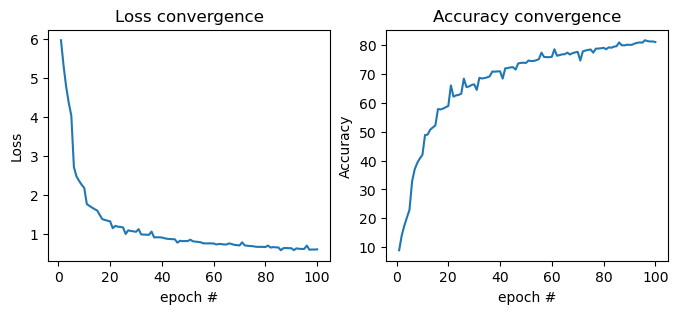

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for axe, metric in zip(axes, ['loss', 'acc']):
    score_history = train_history[f'train_{metric}_hist']
    axe.plot(np.arange(len(score_history))+1, score_history)
    axe.set_xlabel('epoch #')
    if metric == 'loss':
        axe.set_ylabel('Loss')
        axe.title.set_text('Loss convergence')
    else:
        axe.set_ylabel('Accuracy')
        axe.title.set_text('Accuracy convergence')

plt.show()


### 1.4 Evaluating the Model

Evaluate the model taking care that the statistics should not be used from the test set!

Explain why the evaluation needs to be treated differently. 

Print the accuracy of both the train and test set in evaluation mode. Your accuracy should be close to ~80% on both the train and test sets.



In [47]:
### TODO: Evaluate the network
def evaluate(my_nn_func, param_dict, layers_stats_list, dataloader, device):

    total_acc = 0.0
    with torch.no_grad():  
        for i, (data, label) in enumerate(dataloader):

            data = data.to(device)
            label = label.to(device)

            scores = my_nn_func(data, param_dict, layers_stats_list, train=False)  
            total_acc += (scores.max(dim=1)[1] == label).sum() / len(label)

        acc = 100 * (float(total_acc) / len(dataloader)) # with drop_last=True

    return acc

train_acc = evaluate(my_nn, param_dict, layers_stats_list, train_loader, device)
test_acc = evaluate(my_nn, param_dict, layers_stats_list, test_loader, device)
print(f'accuracy_train: {train_acc:.2f}%, accuracy_test: {test_acc:.2f}%')

accuracy_train: 81.32%, accuracy_test: 81.48%


## Exercise 2: Modular Batch Normalization **(OPTIONAL)**


### 2.1 Batch Normalization Module **(OPTIONAL)**

Implement a `torch.nn.Module` that performs the batch normalization operation. 

You will need to use the `register_buffer` in the `__init__` call of your custom `nn.Module` class to create variables that are not in the computation graph but tracked by `nn.Module`. Registering the buffer statistics for example allows the tensor to be moved onto the gpu when `model.cuda()` is called.

**Hint:** You can use the `.training` attribute of `torch.nn.Module` to detect if the model is in `.train()` mode or `.eval()` mode ([example](https://github.com/pytorch/pytorch/blob/fcf8b712348f21634044a5d76a69a59727756357/torch/nn/modules/batchnorm.py#L123)).

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class myBatchnorm(nn.Module):
    def __init__(self, num_features, epsilon=1e-3, momentum=.1):
        super(myBatchnorm,self).__init__()
        self.epsilon = epsilon
        self.m = momentum

        ### TODO: Initialize the `running_mean` and `running_var`
        ### register buffers with 0s and 1s respectively.
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

        ### TODO: Initialize the gamma and beta parameters
        self.gamma = nn.Parameter(torch.ones(num_features, requires_grad=True))
        self.beta = nn.Parameter(torch.zeros(num_features, requires_grad=True))

    def forward(self, x):
        ### TODO: perform batch normalization
        ### HINT: use nn.Module's .training attribute
        ave_mean = self.running_mean
        ave_var = self.running_var
        
        if self.training:
        
            batch_mean = x.mean(0)
            batch_var = x.var(0)
            ave_mean = self.m * batch_mean + (1 - self.m) * ave_mean
            ave_var = self.m * batch_var + (1 - self.m) * ave_var
            self.running_mean = ave_mean
            self.running_var = ave_var

            return self.gamma * ((x - batch_mean) / ((batch_var + self.epsilon) ** 0.5)) + self.beta
        else:

            return self.gamma * ((x - ave_mean) / ((ave_var + self.epsilon) ** 0.5)) + self.beta


# Modify this class with your custom batchnorm
class Model(nn.Module):
    def __init__(self, h1_siz, h2_siz):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(28*28, h1_siz)
        self.linear2 = nn.Linear(h1_siz, h2_siz)
        self.linear3 = nn.Linear(h2_siz, 10)

        ### TODO: initialize batch normalization layers
        self.bn1 = myBatchnorm(h1_siz)
        self.bn2 = myBatchnorm(h2_siz)

        self.init_weights()

    def init_weights(self):
        self.linear1.weight.data.uniform_(-1, 1)
        self.linear1.bias.data.uniform_(-1, 1)
        self.linear2.weight.data.uniform_(-1, 1)
        self.linear2.bias.data.uniform_(-1, 1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear1(x)

        ### TODO: add batch normalization layer
        x = self.bn1(x)
        x = torch.relu(x)
        
        ###
        x = self.linear2(F.relu(x))
        ### TODO: add batch normalization layer
        x = self.bn2(x)

        ###
        x = F.relu(x)
        return self.linear3(x)

### 2.2 Training the Model  **(OPTIONAL)**

Repeat training and overlay the training curves to those from (1.3-1.4) and validate it achieves similar test acc. In order to achieve the same behavior as your `train=False`/`train=True`,  you will need to use `.eval()` and `.train()` methods on your model.

You should get roughly close values to the following:

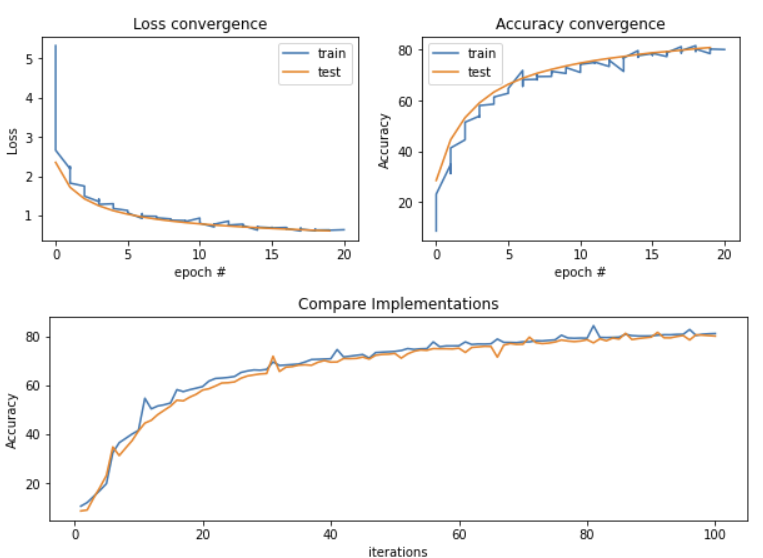

In [55]:
def train(model, optimizer, train_loader, history_frequency=50):
    r"""Iterates over train_loader and optimizes model using pre-initialized
    optimizer.

    Args:
        model (torch.nn.Module): Model to be trained
        optimizer (torch.optim.Optimizer): initialized optimizer with lr and
            model parameters
        train_loader (torch.utils.data.DataLoader): Training set data loader
        history_frequency (int): Frequency for the minibatch metrics to be 
            stored in minibatch_losses and minibatch_accuracies

    Returns:
        minibatch_losses (list of float): Minibatch loss every over the 
            training progress
        minibatch_accuracies (list of float): Minibatch accuracy over the 
            training progress
    """
    minibatch_losses = []
    minibatch_accuracies = []

    ### TODO: Use `.train()` to put model in training state
    model.train()
    total_train_loss = 0.0
    total_train_acc = 0.0
    batch_num = 0.0
    for i,(data,label) in enumerate(train_loader):
        ### TODO: perform forward pass and backpropagation
        data = data.to(device)
        label = label.to(device)

        scores = model(data)
        loss = torch.nn.functional.cross_entropy(scores, label)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
        ### TODO: store the loss and accuracy in `minibatch_losses` and 
        ### `minibatch_accuracies` every `history_frequency`th iteration
        
        batch_num += 1
        total_train_loss += loss.item()
        total_train_acc += (scores.max(dim=1)[1] == label).sum() / len(label)

        # update metrics
        if i % history_frequency == 0:
            # compute accuracy and average of loss every history_frequency iterations
            train_history_loss = total_train_loss / batch_num
            train_history_acc = 100 * (float(total_train_acc) / batch_num)
            minibatch_losses.append(train_history_loss)
            minibatch_accuracies.append(train_history_acc)
            total_train_loss = 0.0
            total_train_acc = 0.0
            batch_num = 0.0

    return minibatch_losses, minibatch_accuracies


def test(model, test_loader):
    r"""Iterate over test_loader to compute the accuracy of the trained model

    Args:
        model (torch.nn.Module): Model to be evaluated
        test_loader (torch.utils.data.DataLoader): Testing set data loader

    Returns:
        accuracy (float): Model accuracy on test set
        loss (float): Model loss on test set
    """
    accuracy = 0
    loss = 0

    ### TODO: Use `.eval()` to put model in evaluation state
    model.eval()
    with torch.no_grad():

        for i,(data,label) in enumerate(test_loader):
            ### TODO: perform forward pass and compute the loss and accuracy
            data = data.to(device)
            label = label.to(device)

            scores = model(data)

            loss += torch.nn.functional.cross_entropy(scores, label).item()
            accuracy += (scores.max(dim=1)[1] == label).sum() / len(label)

        accuracy = 100 * (float(accuracy) / len(test_loader))
        loss = loss / len(test_loader)

    return (loss, accuracy)

In [57]:
# training hyper_parameters
lr = 0.01
num_epochs = 20

### TODO: initialize the model and the optimizer
### Reminder: The running_mean and running_variance are not updated by gradient descent!
model = Model(h1_size, h2_size).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr)

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, optimizer, train_loader)
    train_losses.extend(train_loss)
    train_accuracies.extend(train_accuracy)
    test_loss, test_accuracy = test(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

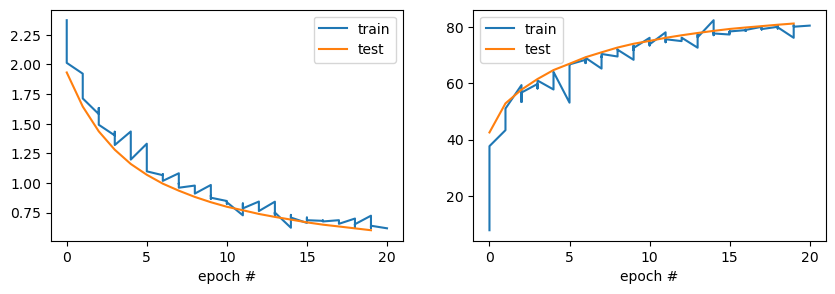

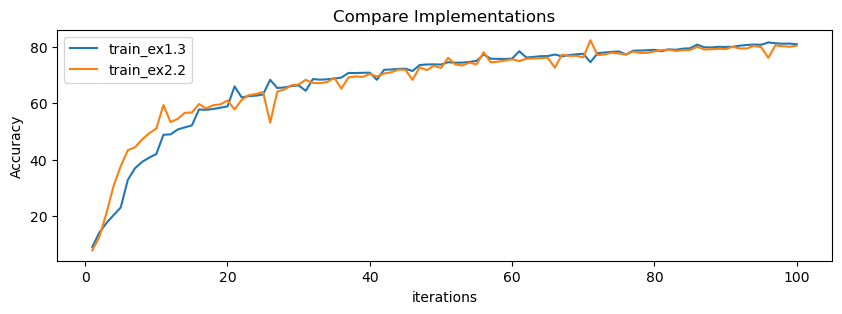

In [59]:
### TODO: Visualize training curves 
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for ax, (metric, train_metric, test_metric) in zip(axes, [("loss", train_losses, test_losses), ("accuracy", train_accuracies, test_accuracies)]):
    ax.plot(np.linspace(0, len(test_metric), len(train_metric)).astype(int), train_metric, label="train")
    ax.plot(np.arange(len(test_metric)), test_metric, label="test")
    ax.set_xlabel('epoch #')
    ax.legend()
    if metric == 'loss':
        axe.set_ylabel('Loss')
        axe.title.set_text('Loss convergence')
    else:
        axe.set_ylabel('Accuracy')
        axe.title.set_text('Accuracy convergence')

fig, axes = plt.subplots(1, 1, figsize=(10, 3))
loss_history = train_history[f'train_acc_hist']
axes.plot(np.arange(len(loss_history))+1, loss_history, label='train_ex1.3')
axes.plot(np.arange(len(train_accuracies))+1, train_accuracies, label='train_ex2.2')
axes.legend()
axes.set_xlabel('iterations')
axes.set_ylabel(name)
axes.title.set_text('Compare Implementations')
plt.show()

### 2.3 PyTorch's nn.BatchNorm1d **(OPTIONAL)**
Finally repeat all these steps using PyTorch's [`nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) module and validate that the training curves match those from (1.3-1.4) and (2.2)

In [63]:
import torch.nn as nn
import torch.nn.functional as F

# Modify this class with your custom batchnorm
class Model(nn.Module):
    def __init__(self, h1_siz, h2_siz):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(28*28, h1_siz)
        self.linear2 = nn.Linear(h1_siz, h2_siz)
        self.linear3 = nn.Linear(h2_siz, 10)
        ### TODO: add batch normalization module
        self.bn1 = nn.BatchNorm1d(h1_siz)
        self.bn2 = nn.BatchNorm1d(h2_siz)

        self.init_weights()

    def init_weights(self):
        self.linear1.weight.data.uniform_(-1,1)
        self.linear1.bias.data.uniform_(-1,1)
        self.linear2.weight.data.uniform_(-1,1)
        self.linear2.bias.data.uniform_(-1,1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = x.view(-1, 28*28)
        x = self.linear1(x)

        ### TODO: add batch normalization layer
        x = self.bn1(x)
        x = torch.relu(x)
        ###
        x = self.linear2(x)
        ### TODO: add batch normalization layer
        x = self.bn2(x)
        
        ###
        x = F.relu(x)
        return self.linear3(x)

In [71]:
# training hyper_parameters
lr = 0.01
num_epochs = 20

### TODO: initialize the model and the optimizer
model = Model(h1_size, h2_size).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr)

train_losses = []
train_accuracies_nn = []

test_losses = []
test_accuracies_nn = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, optimizer, train_loader)
    train_losses.extend(train_loss)
    train_accuracies_nn.extend(train_accuracy)
    test_loss, test_accuracy = test(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies_nn.append(test_accuracy)
    
    print('training loss: ', train_loss)

training loss:  [2.4015209674835205, 2.283125247955322, 2.1611771154403687, 2.0600354719161986, 1.9756932544708252]
training loss:  [1.8986433744430542, 1.857863335609436, 1.7728833508491517, 1.7273098850250244, 1.6590553855895995]
training loss:  [1.603338360786438, 1.5800616121292115, 1.519523561000824, 1.4818319439888001, 1.4470070552825929]
training loss:  [1.422163963317871, 1.3763220620155334, 1.3483214616775512, 1.3109742045402526, 1.2840151047706605]
training loss:  [1.2933015823364258, 1.2244004487991333, 1.2086591053009033, 1.1770995807647706, 1.1611911487579345]
training loss:  [1.1248942613601685, 1.1293319487571716, 1.0944054770469664, 1.094773817062378, 1.0604262125492097]
training loss:  [1.00857412815094, 1.025928921699524, 1.030765620470047, 1.010305142402649, 0.9931017148494721]
training loss:  [0.9640466570854187, 0.9713726282119751, 0.9640186166763306, 0.9600763630867004, 0.9350548815727234]
training loss:  [0.9311408400535583, 0.9236610162258149, 0.9045823192596436

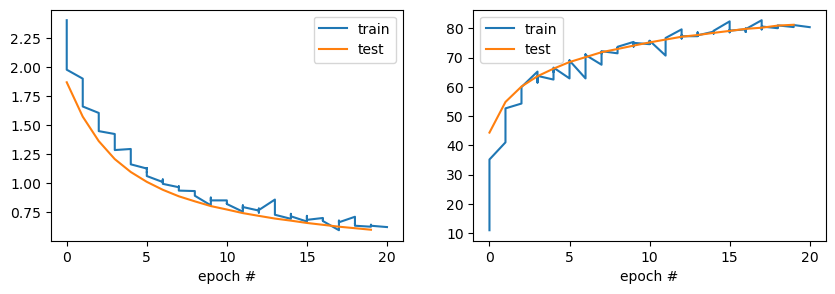

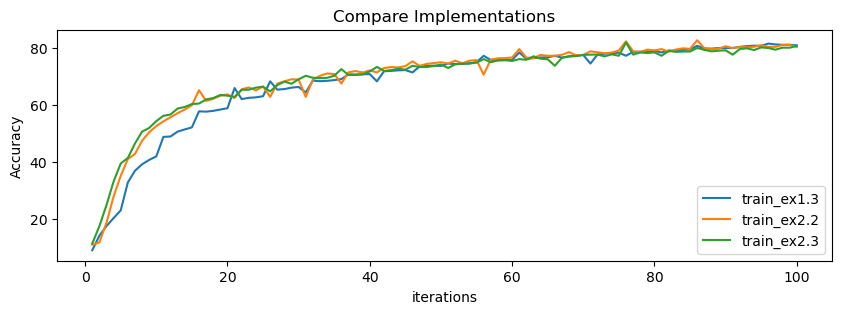

In [75]:
### TODO: Visualize training curves 
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for ax, (metric, train_metric, test_metric) in zip(axes, [("loss", train_losses, test_losses), ("accuracy", train_accuracies, test_accuracies)]):
    ax.plot(np.linspace(0, len(test_metric), len(train_metric)).astype(int), train_metric, label="train")
    ax.plot(np.arange(len(test_metric)), test_metric, label="test")
    ax.set_xlabel('epoch #')
    ax.legend()
    if metric == 'loss':
        axe.set_ylabel('Loss')
        axe.title.set_text('Loss convergence')
    else:
        axe.set_ylabel('Accuracy')
        axe.title.set_text('Accuracy convergence')

# Compare 
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
loss_history = train_history[f'train_acc_hist']
axes.plot(np.arange(len(loss_history))+1, loss_history, label='train_ex1.3')
axes.plot(np.arange(len(train_accuracies))+1, train_accuracies, label='train_ex2.2')
axes.plot(np.arange(len(train_accuracies_nn))+1, train_accuracies_nn, label='train_ex2.3')
axes.legend()
axes.set_xlabel('iterations')
axes.set_ylabel(name)
axes.title.set_text('Compare Implementations')
plt.show()